# Resources

Nice Example:
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

# Implementation of BNN

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

In [40]:
#import and clean data
x_names = ['L', 'b1', 'b2', 'alpha_l', 'b_sec1_b1', 'b_sec2_b1', 'b_sec1_b2', 'b_sec2_b2', 'l_sec', 't_p', 't_w', 'h_w', 'h_F', 'h_S1_3', 'h_S7_9', 'h_v', 'l_v', 'h_b', 'b_b', 'fcc', 'fsy', 'fsu', 'esu', 'd_p_1_o']
x_names=['L']
y_names=['um']
data=pd.concat([pd.read_csv("TestData\\5_CFBSamples.csv")[x_names], pd.read_csv("TestData\\SumRes_5.csv")[y_names]], axis=1)
print(data.head())
data.dropna(axis=0,inplace=True)
x_data=data[x_names]
x_tensor = torch.tensor(x_data.values).float().squeeze()
y_data=data[y_names]
y_tensor = torch.tensor(y_data.values).float().squeeze()
# x_tensor[x_tensor.isnan()=='None']
# x_tensor[0].type()

       L         um
0   4022   0.232343
1   7396   0.044189
2   9413   0.645650
3  15649   4.150488
4  15346  10.450263


In [41]:
data

,L,um
0,4022,0.232343
1,7396,0.044189
2,9413,0.645650
3,15649,4.150488
4,15346,10.450263
...,...,...
2995,8110,0.090632
2996,15365,2.833218
2997,8975,0.118479
2998,8191,0.094324


In [42]:
# Plot true vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(x_data['b1'], y_data, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('True vs Predicted Y Values')
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Perfect predictions line
plt.show()

KeyError: 'b1'

<Figure size 800x800 with 0 Axes>

In [ ]:
# train, test split

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42)
#x_train = x_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)
print(x_train.shape)

print(x_train)
print(y_train)

torch.Size([2395, 24])
tensor([[6.1720e+03, 1.4126e+04, 3.3668e+04,  ..., 8.5000e+02, 8.0001e-01,
         1.8000e+01],
        [1.1701e+04, 1.2123e+04, 3.4945e+04,  ..., 8.5000e+02, 8.0001e-01,
         1.8000e+01],
        [1.0511e+04, 1.4615e+04, 1.6082e+04,  ..., 8.5000e+02, 8.0001e-01,
         1.6000e+01],
        ...,
        [3.5130e+03, 2.7485e+04, 2.0644e+04,  ..., 8.5000e+02, 8.0001e-01,
         2.0000e+01],
        [8.8110e+03, 8.0070e+03, 2.3441e+04,  ..., 8.5000e+02, 8.0001e-01,
         2.2000e+01],
        [7.2480e+03, 2.5500e+04, 1.6637e+04,  ..., 8.5000e+02, 8.0001e-01,
         1.6000e+01]])
tensor([0.5502, 3.1062, 0.2153,  ..., 0.0353, 0.3539, 0.3617])


In [58]:
from sklearn.preprocessing import MinMaxScaler
import torch

# Convert tensors to numpy arrays
x_train_np = x_train.numpy()
x_val_np = x_val.numpy()

# Initialize the MinMaxScaler and fit it on the training data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_np)

# Scale the validation data using the same scaler
x_val_scaled = scaler.transform(x_val_np)

# Convert the scaled arrays back to tensors
x_train = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val = torch.tensor(x_val_scaled, dtype=torch.float32)

In [61]:
mean = x_train.mean(dim=0)
print(mean)
std = x_train.std(dim=0)
print(std)
mean = y_train.mean(dim=0)
print(mean)
std = y_train.std(dim=0)
print(std)

tensor([0.5008, 0.5023, 0.5006, 0.4986, 0.4991, 0.4993, 0.4978, 0.4999, 0.4992,
        0.4997, 0.4977, 0.4992, 0.4984, 0.4974, 0.5041, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4150, 0.5096, 0.5067, 0.5010, 0.4224])
tensor([0.2896, 0.2886, 0.2900, 0.2910, 0.2892, 0.2894, 0.2856, 0.2874, 0.2909,
        0.2900, 0.2880, 0.2894, 0.2894, 0.2902, 0.2906, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2907, 0.2960, 0.2949, 0.2865, 0.2734])
tensor(5.8283)
tensor(76.0193)


In [ ]:
# # Normalisation

# mean = x_train.mean(dim=0)
# std = x_train.std(dim=0)

# x_train_normalized = (x_train - mean) / std
# x_val_normalized = (x_val - mean) / std

# # Handling potential division by zero if a feature has constant value (std = 0)
# x_train_normalized[torch.isnan(x_train_normalized)] = 0
# x_val_normalized[torch.isnan(x_val_normalized)] = 0

In [62]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        # print("mu shape:", mu.shape)
        # print("sigma shape:", sigma.shape)
        # print("y shape:", y.shape)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)

        
        return mu

In [63]:
x_train.shape

torch.Size([2395, 24])

In [85]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(in_dim=24, out_dim=1, hid_dim=20, n_hid_layers=10, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 2500
progress_bar = trange(num_epochs)


losses = []
for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    avg_loss = loss / x_train.shape[0]
    losses.append(avg_loss)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/2500 [00:00<?, ?it/s]

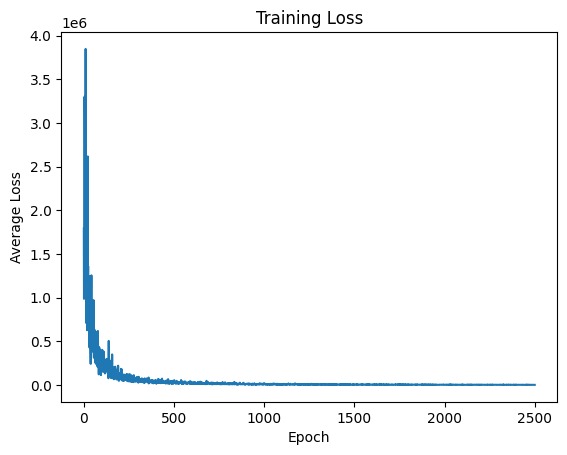

In [86]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

In [87]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_val)

In [88]:
preds['sigma']

tensor([[1.0033],
        [1.0973],
        [1.0634],
        [1.1973],
        [1.0942],
        [0.9965],
        [1.1757],
        [1.1657],
        [1.1988],
        [1.1104],
        [1.2163],
        [1.0278],
        [1.1759],
        [1.0869],
        [1.1632],
        [0.9570],
        [1.1666],
        [1.0807],
        [1.1012],
        [1.2177],
        [1.1105],
        [1.0959],
        [1.1883],
        [1.1426],
        [1.0566],
        [0.9471],
        [1.0336],
        [1.1529],
        [1.0976],
        [1.0704],
        [1.1354],
        [1.2261],
        [1.0562],
        [1.1261],
        [1.0375],
        [1.0186],
        [1.0360],
        [1.1030],
        [1.0254],
        [1.2494],
        [1.1551],
        [1.1696],
        [1.1293],
        [1.0120],
        [1.2511],
        [1.1236],
        [1.1561],
        [1.0985],
        [1.1001],
        [1.1619],
        [1.0740],
        [0.9926],
        [1.1545],
        [0.9576],
        [1.2284],
        [1

In [89]:
y_pred = preds['obs'].mean(0)
y_pred

tensor([ 2.3451,  2.2096,  2.3791,  2.3537,  2.3862,  2.4395,  2.3384,  2.4514,
         2.9574,  2.2997,  2.4041,  2.4703,  2.3835,  2.3851,  2.3846,  2.3590,
         2.3827,  2.3428,  2.3894,  2.4316,  2.2603,  2.4582,  2.3859,  4.6449,
         2.3925,  6.2753,  2.3607,  2.2616,  2.4623,  2.3385,  2.3578,  2.4325,
         2.3199,  5.4340,  2.4216,  2.4284,  2.4372,  2.4658,  2.2928,  2.4091,
         2.3503,  2.4521,  2.3416,  2.3747,  2.2888,  3.6057,  2.3441,  2.3875,
         2.3447,  5.0649,  2.2983,  5.7376,  2.3441,  2.3963,  2.3477,  2.2977,
         2.3211,  2.3936,  2.4057,  2.3491,  2.5792,  2.8597,  2.3697,  2.2395,
         2.3870,  2.3788,  2.4312,  2.4329,  2.3886,  2.4037,  2.3189,  2.4617,
         2.4272,  9.8654,  2.3372,  2.3443,  2.3746,  2.3683,  2.4482,  2.3948,
         2.4788, 26.7117,  2.3201,  2.3526,  2.3543,  6.2654,  2.3675,  2.4014,
         2.3354,  2.3873,  2.3525,  2.3943,  2.5071,  2.3814,  2.3085,  2.4581,
         2.3113,  7.7253,  2.2980,  2.30

In [90]:
# y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
# print(y_pred)
y_pred= preds['obs'][0]
print(y_pred)

tensor([ 2.1769e+00,  3.3481e+00,  4.6709e+00,  3.4055e+00,  1.9185e+00,
         3.3419e+00,  2.3377e+00,  3.1465e+00,  1.5068e+00,  9.9651e-01,
         2.7611e+00,  3.3502e+00,  1.2997e+00,  1.3782e+00,  3.0653e+00,
         3.7179e+00,  1.9344e+00,  3.2833e+00,  4.2454e+00,  2.1001e+00,
         4.7021e-01,  2.3376e+00,  2.6846e+00,  1.9818e+00,  3.5418e+00,
         2.5668e+00,  4.7840e+00,  2.8865e+00,  2.9515e+00,  4.5194e+00,
         2.2992e+00,  2.9104e+00,  2.4032e+00,  3.5147e+01,  2.4018e+00,
         2.2631e+00,  1.8639e+00,  2.7696e+00,  9.4740e-01,  2.9918e+00,
         2.3747e+00,  8.9111e-01,  3.5808e+00,  2.4487e+00,  1.5899e+00,
         2.0434e+00,  2.5696e+00,  2.4115e+00,  3.4030e+00,  1.3455e+00,
         2.0315e+00,  2.9990e+00,  3.7826e+00,  1.4191e+00,  1.5001e+00,
         1.3075e+00,  5.3664e-01,  2.8092e+00,  2.3588e+00,  1.9869e+00,
         2.2573e+00,  2.4722e+00,  3.7987e+00,  2.6613e+00,  1.1933e+00,
         3.4563e+00,  3.2719e+00,  1.9699e+00,  3.6

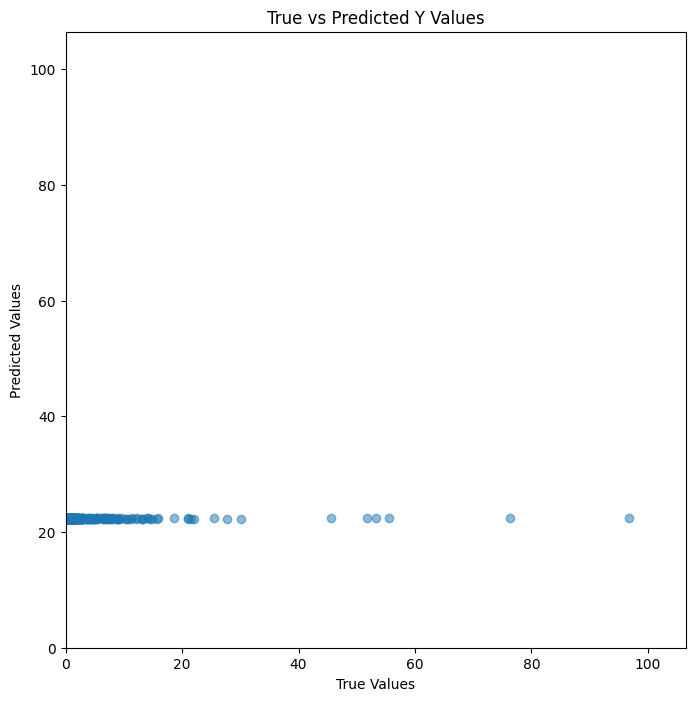

In [91]:
# Plot true vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_val, predicted_y_mean, alpha=0.5)
max_value = max(y_val.max(), predicted_y_mean.max())
min_value = min(y_val.min(), predicted_y_mean.min())
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Y Values')
plt.xlim(-0.1 * min_value, 1.1 * max_value)
plt.ylim(-0.1 * min_value, 1.1 * max_value)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Perfect predictions line
plt.show()

In [92]:
#Assuming y_val and y_pred are PyTorch tensors
# Calculate the squared differences
squared_diff = (y_val - y_pred) ** 2

# Calculate the mean of squared differences
mean_squared_diff = torch.mean(squared_diff)

# Calculate RMSE
rmse = torch.sqrt(mean_squared_diff)

print("Root Mean Squared Error (RMSE):", rmse.item())

Root Mean Squared Error (RMSE): 6.234586238861084


In [81]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    # xlims = [-0.5, 1.5]
    # ylims = [-1.5, 2.5]
    # plt.xlim(xlims)
    # plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    #ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_train[:, 0] , y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_train[:, 0], y_train, 'ko', markersize=3)
    ax.plot(x_val[:, 0], y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_val[:, 0], y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

In [83]:
x_train[:, 0]

tensor([0.2136, 0.6560, 0.5608,  ..., 0.0008, 0.4248, 0.2997])

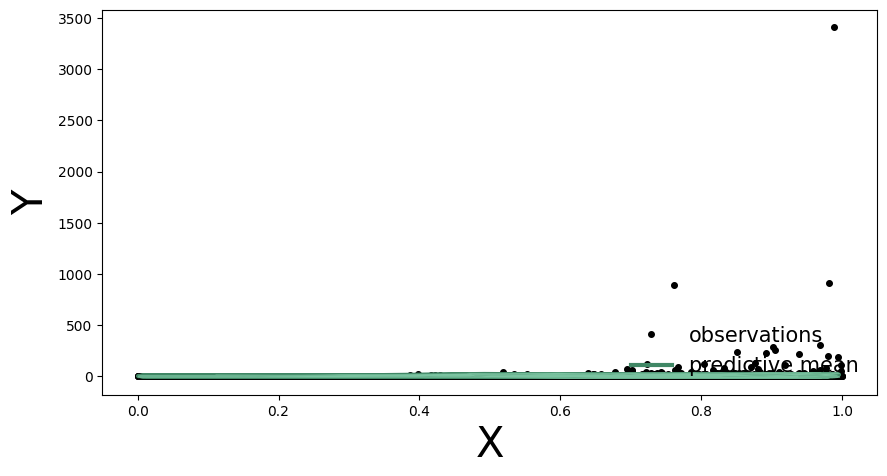

In [84]:
plot_predictions(preds)